In [ ]:
from langchain_ollama import ChatOllama

In [1]:
%pip install langgraph

  Using cached msgpack-1.1.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (8.4 kB)
Using cached msgpack-1.1.0-cp311-cp311-macosx_11_0_arm64.whl (81 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
def function_1(input_1):
    return input_1 + " Hi"

def function_2(input_2):
    return input_2 + " there"

In [3]:
from langgraph.graph import Graph

workflow = Graph()

workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)

workflow.add_edge("node_1", "node_2")
workflow.set_entry_point("node_1")
workflow.set_finish_point("node_2")

app = workflow.compile()

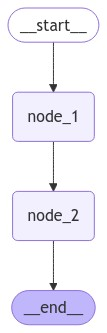

In [6]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [7]:
app.invoke("Hello")

'Hello Hi there'

In [9]:
input = "Hello"
print(f"Input: {input}")
for output in app.stream(input):
    for key, value in output.items():
        print(f"Output from node '{key}': {value}")
        print("-" * 50)
        print(value)
    print("-" * 50)

Input: Hello
Output from node 'node_1': Hello Hi
--------------------------------------------------
Hello Hi
--------------------------------------------------
Output from node 'node_2': Hello Hi there
--------------------------------------------------
Hello Hi there
--------------------------------------------------


### Adding LLM Call

In [10]:
%pip install langchain_ollama langchain langchain_community

Note: you may need to restart the kernel to use updated packages.


In [12]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.1",
    temperature=0
)

llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-11-09T16:00:40.121851Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 3757299125, 'load_duration': 3098578041, 'prompt_eval_count': 11, 'prompt_eval_duration': 183935000, 'eval_count': 10, 'eval_duration': 471723000}, id='run-1b26574d-d009-4dd6-90a6-fd4fd2629f61-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21})

In [13]:
llm.invoke("Hello").content

'Hello! How can I assist you today?'

In [18]:
def function_1(input_1):
    return llm.invoke(input_1).content

def function_2(input_2):
    return "From Agent the output is: " + input_2

In [19]:
workflow = Graph()

workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)

workflow.add_edge("node_1", "node_2")
workflow.set_entry_point("node_1")
workflow.set_finish_point("node_2")

app = workflow.compile()

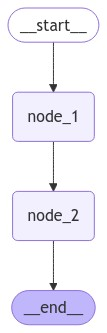

In [20]:
display(Image(app.get_graph().draw_mermaid_png()))

In [21]:
app.invoke("Hello")

'From Agent the output is: Hello! How can I assist you today?'

In [22]:
input = "Hello"
print(f"Input: {input}")
for output in app.stream(input):
    for key, value in output.items():
        print(f"Output from node '{key}': {value}")
        print("-" * 50)
        print(value)
    print("-" * 50)

Input: Hello
Output from node 'node_1': Hello! How can I assist you today?
--------------------------------------------------
Hello! How can I assist you today?
--------------------------------------------------
Output from node 'node_2': From Agent the output is: Hello! How can I assist you today?
--------------------------------------------------
From Agent the output is: Hello! How can I assist you today?
--------------------------------------------------


### Parse City name

In [23]:
def function_1(input_1):
    extract_city = "Your task is to provide the only city name based on the user' input.\
        Nothing else. Only the city name that the user mentioned. Following is\
        the user input: "+input_1
    return llm.invoke(extract_city).content

def function_2(input_2):
    return "The city name is: " + input_2

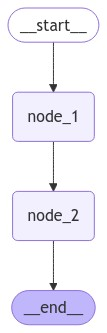

In [24]:
workflow = Graph()

workflow.add_node("node_1", function_1)
workflow.add_node("node_2", function_2)

workflow.add_edge("node_1", "node_2")
workflow.set_entry_point("node_1")
workflow.set_finish_point("node_2")

app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [25]:
app.invoke("What is the weather in Dhaka?")

'The city name is: Dhaka'

### Search Agent

In [26]:
import os
from dotenv import load_dotenv

load_dotenv()

api_key = os.getenv("TAVILY_API_KEY")

In [50]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults(api_key=api_key, max_results=3)


In [52]:
results = search.invoke("Recent news in Dhaka")

In [54]:
content = ""
for result in results:
    content += result["content"]

In [55]:
content

"The sustained protests that convulsed Bangladesh in recent weeks were a backlash against Ms. Hasina's formula for power: absolute, disconnected and entitled. ... Wild with glee over news ofLatest News. West Indies bowler Joseph suspended after storming off field. Alzarri Joseph was hit with a 2-match suspension Thursday after storming off the field during the series-clinching ODI win over England. 4 hours 41 minutes ago. ... 8/C, FR Tower, Panthapath, Dhaka 1207, Bangladesh.Dhaka Tribune is one of the fastest-growing news sites in Bangladesh, due to its reputation of neutral coverage and intelligent analysis. A young group of... Saturday, November 09, 2024"

In [56]:
def function_1(input_1):
    extract_search_query = "Your task is to provide the only search query based on the user's input.\
        Nothing else. Only the search query that the user mentioned. This will be use to search the web.\
        Following is the user input: "+input_1
    return llm.invoke(extract_search_query).content

def function_2(input_2):
    search_results = search.run(input_2)
    content = ""
    for result in search_results:
        content += result["content"]
    answer_prompt = "Your task is to provide the only answer based on the search results.\
        Following is the user input: "+input_2+"\
        Here is the search results: "+content
    return llm.invoke(answer_prompt).content
workflow = Graph()

workflow.add_node("agent_node", function_1)
workflow.add_node("search_node", function_2)

workflow.add_edge("agent_node", "search_node")

workflow.set_entry_point("agent_node")
workflow.set_finish_point("search_node")

app = workflow.compile()


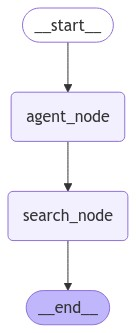

In [57]:
display(Image(app.get_graph().draw_mermaid_png()))

In [61]:
input = "Who is chief advisor of Bangladesh interim government?"

for output in app.stream(input):
    for key, value in output.items():
        print(f"Output from node '{key}': {value}")
        print("-" * 50)
        print(value)
    print("-" * 50)

Output from node 'agent_node': "Chief advisor of Bangladesh interim government"
--------------------------------------------------
"Chief advisor of Bangladesh interim government"
--------------------------------------------------
Output from node 'search_node': Muhammad Yunus.
--------------------------------------------------
Muhammad Yunus.
--------------------------------------------------


In [62]:
app.invoke("tell me the history of Bangladesh")

"Here's the answer based on the search results:\n\n**History of Bangladesh**\n\nFor centuries, the area that is now Bangladesh was part of the Bengal region of India, ruled by empires such as the Maurya (321-184 BCE) to the Mughal (1526-1858 CE). The British took control of the region and created their Raj in India (1858-1947), including Bangladesh. Bangladesh did not exist as an independent state until 1971, when it gained independence from Pakistan after a long struggle for freedom.\n\n**Timeline:**\n\n* Maurya Empire (321-184 BCE)\n* Mughal Empire (1526-1858 CE)\n* British Raj in India (1858-1947)\n* Creation of Bangladesh as an independent state (1971)\n\nNote: This is a brief summary based on the search results. If you need more information or details, please let me know!"